# Importação de módulos

In [1]:
%matplotlib inline
import random
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from keras import backend as K
import psutil
import os 
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import np_utils
K.set_image_dim_ordering('th')
import time

num_cores = psutil.cpu_count()
GPU= True

if GPU:
    num_GPU = 1
    num_CPU = 1
    print('Usando a GPU')
else:
    num_CPU = 1
    num_GPU = 0
    print('Usando apenas o CPU')

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

Using TensorFlow backend.


Usando a GPU


# Tratamento de Dados

### Carregamento de dados

Os dados são treinados são carregados, separando-se entre os dados contendo features e labels. Os dados de imagens são rotacionados para ficarem na posição correta.

In [2]:
mnist = np.loadtxt('../data/exdata.csv', delimiter=',')

data = mnist[:-1].T
data = np.array(list(map(lambda d: d.reshape((20,20)).T.flatten(), data)))
target = mnist[-1]

target[target == 10] = 0

### Exemplos de imagens do conjunto de dados

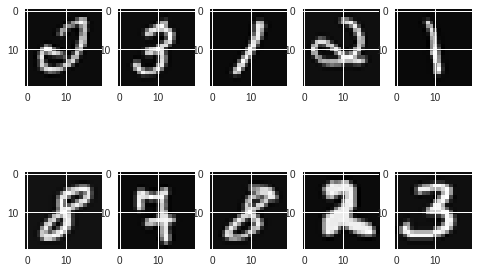

In [3]:
rows = 2
cols = 5
f, axarr = plt.subplots(rows, cols)
for r in range(rows):
    for c in range(cols):
        rand_data = random.choice(data)
        axarr[r, c].imshow(rand_data.reshape((20,20)), cmap=plt.get_cmap('gray'))

### Normalização de dados

A saída é normalizada através do OneHotEncoder, que transforma o valor do target em um vetor de zeros e valor 1 no índicie correspondente ao valor do target

In [4]:
target_scaler = OneHotEncoder()
target_normalized = target_scaler.fit_transform(target.reshape((-1, 1))).todense()

### Separação de dados treinano/teste

15% dos dados serão separados para teste

In [6]:
data_train, data_test, target_train, target_test = train_test_split(
    data,
    target_normalized,
    train_size=(85/100),
)

## Definição da arquitetura

|       Camada     |    Neurônios |
|---------------------------------|
|entrada           | 400          |
|hidden layer      | 205          |
|          saída   | 10           |

In [7]:
def mlp():
    model = Sequential()
    model.add(Dense(205, input_dim=400, kernel_initializer="normal"))
    model.add(Activation('relu'))
    model.add(Dense(10, kernel_initializer="normal"))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Treinamento da rede

In [8]:
model = mlp()

start_time = time.time()

treinar = True
if treinar:
    print("Treinando a rede")
    model.fit(data_train, 
              target_train, 
              validation_data=(data_test, target_test), 
              epochs=100, 
              batch_size=150, 
              verbose=0
             )
    model.save_weights("mlp.h5")
    print("Pesos salvos")
else:
    model.load_weights("mlp.h5")
    print("Pesos recuperados do disco")

scores = model.evaluate(data_test, target_test, verbose=0)

print("Baseline Error: %.2f%%" % (100-scores[1]*100))
print("Rede treinada/buscada em %.2f segundos" % (time.time() - start_time))

Treinando a rede
Pesos salvos
Baseline Error: 6.00%
Rede treinada/buscada em 17.76 segundos


## Resultados

#### Teste Utilizando Todos os Dados

In [9]:
predictions_all = model.predict(data)
predictions_all = np.argmax(predictions_all, axis=1)
print("Test set accuracy: {:.2%}".format(
    metrics.accuracy_score(target, predictions_all)))

Test set accuracy: 99.10%



Matriz de confusão para todo o conjunto de dados.

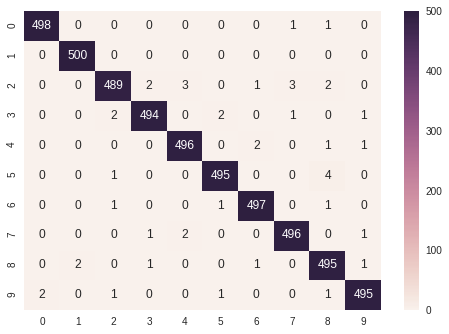

In [10]:
confusion_matrix = metrics.confusion_matrix(target, predictions_all)
sn.heatmap(confusion_matrix, annot=True, fmt='d')

In [11]:
print(metrics.classification_report(target, predictions_all))

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       500
        1.0       1.00      1.00      1.00       500
        2.0       0.99      0.98      0.98       500
        3.0       0.99      0.99      0.99       500
        4.0       0.99      0.99      0.99       500
        5.0       0.99      0.99      0.99       500
        6.0       0.99      0.99      0.99       500
        7.0       0.99      0.99      0.99       500
        8.0       0.98      0.99      0.99       500
        9.0       0.99      0.99      0.99       500

avg / total       0.99      0.99      0.99      5000



#### Teste Utilizando Apenas o Conjunto de Teste

In [12]:
predictions = model.predict(data_test)
predictions = np.argmax(predictions, axis=1)
target_test_classes = np.asarray(target_test.argmax(axis=1)).reshape(-1)
print("Test set accuracy: {:.2%}".format(
    metrics.accuracy_score(target_test_classes, predictions)))

Test set accuracy: 94.00%



Matriz de confusão para o conjunto teste.

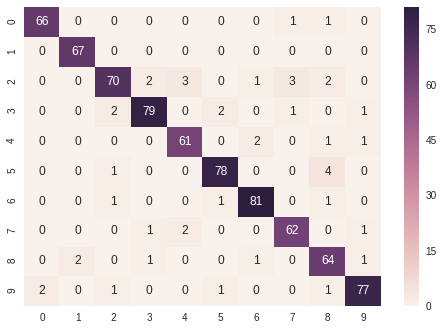

In [13]:
confusion_matrix = metrics.confusion_matrix(target_test_classes, predictions)
sn.heatmap(confusion_matrix, annot=True, fmt='d')

In [14]:
print(metrics.classification_report(target_test_classes, predictions))

             precision    recall  f1-score   support

          0       0.97      0.97      0.97        68
          1       0.97      1.00      0.99        67
          2       0.93      0.86      0.90        81
          3       0.95      0.93      0.94        85
          4       0.92      0.94      0.93        65
          5       0.95      0.94      0.95        83
          6       0.95      0.96      0.96        84
          7       0.93      0.94      0.93        66
          8       0.86      0.93      0.90        69
          9       0.95      0.94      0.94        82

avg / total       0.94      0.94      0.94       750



### Alguns erros de classificação

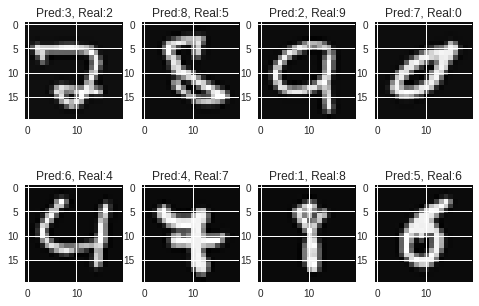

In [15]:
wrong_class = [i for i in range(predictions.size) if predictions[i]!=target_test_classes[i]]
rows = 2
cols = 4
f, axarr = plt.subplots(rows, cols)
for r in range(rows):
    for c in range(cols):
        rand_i = random.choice(wrong_class)
        axarr[r, c].imshow(data_test[rand_i].reshape((20,20)), cmap=plt.get_cmap('gray'))
        axarr[r, c].set_title('Pred:{}, Real:{}'.format(predictions[rand_i], 
                                                        target_test_classes[rand_i]))

# Classificação de novos dados

[ 0.83503062  0.05407155]
[5 3]


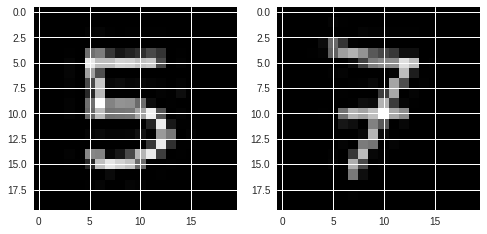

In [16]:
from PIL import Image
import matplotlib.image as mpimg
from resizeimage import resizeimage


with open('5.png', 'r+b') as f:
    with Image.open(f) as image:
        cover = resizeimage.resize_cover(image, [20, 20]).convert('L')
        cover.save('5inho.png', image.format)
with open('7.png', 'r+b') as f:
    with Image.open(f) as image:
        cover = resizeimage.resize_cover(image, [20, 20]).convert('L')
        cover.save('7inho.png', image.format)
img5 = mpimg.imread('5inho.png').flatten()
img7 = mpimg.imread('7inho.png').flatten()
img = np.vstack((img5,img7))
y = model.predict(img)
output = y.argmax(axis=1)
print(y[0][output])
print(output)
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(img5.reshape((20,20)), cmap=plt.get_cmap('gray'))
axarr[1].imshow(img7.reshape((20,20)), cmap=plt.get_cmap('gray'))